In [65]:
import model
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os

In [66]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
network = model.get_network(model.Network.GROUP_NORM).to(device)
summary(network, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
         GroupNorm-3           [-1, 10, 28, 28]              20
         Dropout2d-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,456
              ReLU-6           [-1, 16, 28, 28]               0
         GroupNorm-7           [-1, 16, 28, 28]              32
         Dropout2d-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             136
             ReLU-11            [-1, 8, 14, 14]               0
        GroupNorm-12            [-1, 8, 14, 14]              16
    

/content/model.py:114: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [67]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [68]:
from tqdm import tqdm


gn_train_losses, gn_train_acc, gn_test_losses, gn_test_acc = [], [], [], []
ln_train_losses, ln_train_acc, ln_test_losses, ln_test_acc = [], [], [], []
bn_train_losses, bn_train_acc, bn_test_losses, bn_test_acc = [], [], [], []


def train(model, device, train_loader, optimizer, epoch, use_lambda = False):
    train_losses = []
    train_acc = []
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    lambda_l1 = 0.0004

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        y_pred = model(data)

        loss = F.nll_loss(y_pred, target)

        if use_lambda :
          l1 = 0
          for params in model.parameters():
            l1 = l1 + params.abs().sum()
          '''  
          #lambda_l1 = 0.0004
          if lambda_l1 == 0: #First epoch lambda calculation
            lambda_l1 = loss/(l1*10)
            print('loss: ', loss)
            print('l1: ', l1)
            print('lambda_l1: ', lambda_l1)
          '''
          loss = loss + lambda_l1*l1

        train_losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Epoch={epoch} Loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}%')
        train_acc.append(100*correct/processed)

    return train_losses, train_acc

def test(model, device, test_loader):
    test_losses = []
    test_acc = []
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_losses, test_acc

In [69]:
network = model.get_network(model.Network.GROUP_NORM).to(device)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


for epoch in range(1, 16):
    gn_train_losses, gn_train_acc = train(network, device, train_loader, optimizer, epoch)
    gn_test_losses, gn_test_acc = test(network, device, test_loader)

Epoch=1 Loss=0.16668304800987244 batch_id=937 Accuracy=87.09%: 100%|██████████| 938/938 [00:31<00:00, 30.18it/s]



Test set: Average loss: 0.0709, Accuracy: 9790/10000 (97.90%)



Epoch=2 Loss=0.01708497293293476 batch_id=937 Accuracy=96.82%: 100%|██████████| 938/938 [00:23<00:00, 40.04it/s]



Test set: Average loss: 0.0504, Accuracy: 9840/10000 (98.40%)



Epoch=3 Loss=0.07135476171970367 batch_id=937 Accuracy=97.60%: 100%|██████████| 938/938 [00:23<00:00, 40.18it/s]



Test set: Average loss: 0.0405, Accuracy: 9875/10000 (98.75%)



Epoch=4 Loss=0.02431211993098259 batch_id=937 Accuracy=97.89%: 100%|██████████| 938/938 [00:23<00:00, 40.46it/s]



Test set: Average loss: 0.0359, Accuracy: 9885/10000 (98.85%)



Epoch=5 Loss=0.19106103479862213 batch_id=937 Accuracy=98.15%: 100%|██████████| 938/938 [00:24<00:00, 38.94it/s]



Test set: Average loss: 0.0366, Accuracy: 9883/10000 (98.83%)



Epoch=6 Loss=0.08063753694295883 batch_id=937 Accuracy=98.21%: 100%|██████████| 938/938 [00:23<00:00, 39.93it/s]



Test set: Average loss: 0.0300, Accuracy: 9907/10000 (99.07%)



Epoch=7 Loss=0.07980476319789886 batch_id=937 Accuracy=98.42%: 100%|██████████| 938/938 [00:23<00:00, 40.24it/s]



Test set: Average loss: 0.0289, Accuracy: 9904/10000 (99.04%)



Epoch=8 Loss=0.03794737905263901 batch_id=937 Accuracy=98.50%: 100%|██████████| 938/938 [00:23<00:00, 40.46it/s]



Test set: Average loss: 0.0281, Accuracy: 9909/10000 (99.09%)



Epoch=9 Loss=0.039126764982938766 batch_id=937 Accuracy=98.50%: 100%|██████████| 938/938 [00:23<00:00, 40.37it/s]



Test set: Average loss: 0.0291, Accuracy: 9911/10000 (99.11%)



Epoch=10 Loss=0.12496215850114822 batch_id=937 Accuracy=98.69%: 100%|██████████| 938/938 [00:23<00:00, 40.56it/s]



Test set: Average loss: 0.0268, Accuracy: 9912/10000 (99.12%)



Epoch=11 Loss=0.029042044654488564 batch_id=937 Accuracy=98.69%: 100%|██████████| 938/938 [00:23<00:00, 40.51it/s]



Test set: Average loss: 0.0273, Accuracy: 9904/10000 (99.04%)



Epoch=12 Loss=0.002360033802688122 batch_id=937 Accuracy=98.83%: 100%|██████████| 938/938 [00:22<00:00, 40.78it/s]



Test set: Average loss: 0.0280, Accuracy: 9907/10000 (99.07%)



Epoch=13 Loss=0.012500545009970665 batch_id=937 Accuracy=98.75%: 100%|██████████| 938/938 [00:22<00:00, 40.80it/s]



Test set: Average loss: 0.0262, Accuracy: 9915/10000 (99.15%)



Epoch=14 Loss=0.061388783156871796 batch_id=937 Accuracy=98.83%: 100%|██████████| 938/938 [00:22<00:00, 40.91it/s]



Test set: Average loss: 0.0255, Accuracy: 9910/10000 (99.10%)



Epoch=15 Loss=0.05694323405623436 batch_id=937 Accuracy=98.84%: 100%|██████████| 938/938 [00:22<00:00, 40.82it/s]



Test set: Average loss: 0.0226, Accuracy: 9923/10000 (99.23%)



In [70]:
network = model.get_network(model.Network.LAYER_NORM).to(device)
summary(network, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
         LayerNorm-3           [-1, 10, 28, 28]          15,680
         Dropout2d-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,456
              ReLU-6           [-1, 16, 28, 28]               0
         LayerNorm-7           [-1, 16, 28, 28]          25,088
         Dropout2d-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             136
             ReLU-11            [-1, 8, 14, 14]               0
        LayerNorm-12            [-1, 8, 14, 14]           3,136
        Dropout2d-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 16,

/content/model.py:211: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [71]:
#network = model.get_network(model.Network.LAYER_NORM).to(device)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


for epoch in range(1, 16):
    ln_train_losses, ln_train_acc = train(network, device, train_loader, optimizer, epoch)
    ln_test_losses, ln_test_acc = test(network, device, test_loader)

Epoch=1 Loss=0.3548341393470764 batch_id=937 Accuracy=88.89%: 100%|██████████| 938/938 [00:29<00:00, 31.78it/s]



Test set: Average loss: 0.0816, Accuracy: 9764/10000 (97.64%)



Epoch=2 Loss=0.0438757985830307 batch_id=937 Accuracy=96.84%: 100%|██████████| 938/938 [00:22<00:00, 41.92it/s]



Test set: Average loss: 0.0483, Accuracy: 9869/10000 (98.69%)



Epoch=3 Loss=0.27899566292762756 batch_id=937 Accuracy=97.69%: 100%|██████████| 938/938 [00:22<00:00, 41.84it/s]



Test set: Average loss: 0.0379, Accuracy: 9885/10000 (98.85%)



Epoch=4 Loss=0.1767095923423767 batch_id=937 Accuracy=98.07%: 100%|██████████| 938/938 [00:22<00:00, 42.05it/s]



Test set: Average loss: 0.0333, Accuracy: 9900/10000 (99.00%)



Epoch=5 Loss=0.09356789290904999 batch_id=937 Accuracy=98.32%: 100%|██████████| 938/938 [00:23<00:00, 39.97it/s]



Test set: Average loss: 0.0346, Accuracy: 9892/10000 (98.92%)



Epoch=6 Loss=0.192585289478302 batch_id=937 Accuracy=98.39%: 100%|██████████| 938/938 [00:22<00:00, 41.90it/s]



Test set: Average loss: 0.0291, Accuracy: 9917/10000 (99.17%)



Epoch=7 Loss=0.15229684114456177 batch_id=937 Accuracy=98.48%: 100%|██████████| 938/938 [00:22<00:00, 41.70it/s]



Test set: Average loss: 0.0283, Accuracy: 9910/10000 (99.10%)



Epoch=8 Loss=0.02258310094475746 batch_id=937 Accuracy=98.64%: 100%|██████████| 938/938 [00:22<00:00, 41.52it/s]



Test set: Average loss: 0.0247, Accuracy: 9921/10000 (99.21%)



Epoch=9 Loss=0.08212585747241974 batch_id=937 Accuracy=98.71%: 100%|██████████| 938/938 [00:22<00:00, 41.72it/s]



Test set: Average loss: 0.0239, Accuracy: 9928/10000 (99.28%)



Epoch=10 Loss=0.032763395458459854 batch_id=937 Accuracy=98.74%: 100%|██████████| 938/938 [00:22<00:00, 41.86it/s]



Test set: Average loss: 0.0245, Accuracy: 9926/10000 (99.26%)



Epoch=11 Loss=0.19407568871974945 batch_id=937 Accuracy=98.85%: 100%|██████████| 938/938 [00:22<00:00, 41.57it/s]



Test set: Average loss: 0.0244, Accuracy: 9928/10000 (99.28%)



Epoch=12 Loss=0.046016041189432144 batch_id=937 Accuracy=98.88%: 100%|██████████| 938/938 [00:22<00:00, 42.27it/s]



Test set: Average loss: 0.0227, Accuracy: 9929/10000 (99.29%)



Epoch=13 Loss=0.002899480750784278 batch_id=937 Accuracy=98.88%: 100%|██████████| 938/938 [00:22<00:00, 41.74it/s]



Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)



Epoch=14 Loss=0.028554340824484825 batch_id=937 Accuracy=98.95%: 100%|██████████| 938/938 [00:22<00:00, 41.98it/s]



Test set: Average loss: 0.0234, Accuracy: 9918/10000 (99.18%)



Epoch=15 Loss=0.014838756062090397 batch_id=937 Accuracy=98.95%: 100%|██████████| 938/938 [00:22<00:00, 41.38it/s]



Test set: Average loss: 0.0228, Accuracy: 9928/10000 (99.28%)



In [72]:
network = model.get_network(model.Network.BATCH_NORM).to(device)
summary(network, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
         Dropout2d-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,456
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
         Dropout2d-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             136
             ReLU-11            [-1, 8, 14, 14]               0
      BatchNorm2d-12            [-1, 8, 14, 14]              16
        Dropout2d-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 16,

/content/model.py:308: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [73]:
network = model.get_network(model.Network.BATCH_NORM).to(device)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


for epoch in range(1, 16):
    bn_train_losses, bn_train_acc = train(network, device, train_loader, optimizer, epoch, use_lambda = True)
    bn_test_losses, bn_test_acc = test(network, device, test_loader)

Epoch=1 Loss=0.40912705659866333 batch_id=937 Accuracy=90.55%: 100%|██████████| 938/938 [00:25<00:00, 37.45it/s]



Test set: Average loss: 0.0655, Accuracy: 9798/10000 (97.98%)



Epoch=2 Loss=0.27819719910621643 batch_id=937 Accuracy=96.72%: 100%|██████████| 938/938 [00:24<00:00, 37.71it/s]



Test set: Average loss: 0.0534, Accuracy: 9815/10000 (98.15%)



Epoch=3 Loss=0.2344641536474228 batch_id=937 Accuracy=97.14%: 100%|██████████| 938/938 [00:25<00:00, 37.47it/s]



Test set: Average loss: 0.0518, Accuracy: 9840/10000 (98.40%)



Epoch=4 Loss=0.5111068487167358 batch_id=937 Accuracy=97.23%: 100%|██████████| 938/938 [00:25<00:00, 37.39it/s]



Test set: Average loss: 0.0464, Accuracy: 9846/10000 (98.46%)



Epoch=5 Loss=0.2159246951341629 batch_id=937 Accuracy=97.38%: 100%|██████████| 938/938 [00:24<00:00, 37.75it/s]



Test set: Average loss: 0.0396, Accuracy: 9872/10000 (98.72%)



Epoch=6 Loss=0.31574997305870056 batch_id=937 Accuracy=97.45%: 100%|██████████| 938/938 [00:24<00:00, 37.64it/s]



Test set: Average loss: 0.0516, Accuracy: 9843/10000 (98.43%)



Epoch=7 Loss=0.2412162870168686 batch_id=937 Accuracy=97.44%: 100%|██████████| 938/938 [00:24<00:00, 37.55it/s]



Test set: Average loss: 0.0486, Accuracy: 9850/10000 (98.50%)



Epoch=8 Loss=0.36183294653892517 batch_id=937 Accuracy=97.60%: 100%|██████████| 938/938 [00:25<00:00, 37.44it/s]



Test set: Average loss: 0.0442, Accuracy: 9855/10000 (98.55%)



Epoch=9 Loss=0.28362220525741577 batch_id=937 Accuracy=97.50%: 100%|██████████| 938/938 [00:27<00:00, 34.54it/s]



Test set: Average loss: 0.0395, Accuracy: 9875/10000 (98.75%)



Epoch=10 Loss=0.2215401530265808 batch_id=937 Accuracy=97.66%: 100%|██████████| 938/938 [00:27<00:00, 34.25it/s]



Test set: Average loss: 0.0404, Accuracy: 9871/10000 (98.71%)



Epoch=11 Loss=0.2815726101398468 batch_id=937 Accuracy=97.69%: 100%|██████████| 938/938 [00:25<00:00, 37.15it/s]



Test set: Average loss: 0.0538, Accuracy: 9815/10000 (98.15%)



Epoch=12 Loss=0.22547325491905212 batch_id=937 Accuracy=97.65%: 100%|██████████| 938/938 [00:24<00:00, 37.78it/s]



Test set: Average loss: 0.0389, Accuracy: 9872/10000 (98.72%)



Epoch=13 Loss=0.19797149300575256 batch_id=937 Accuracy=97.78%: 100%|██████████| 938/938 [00:25<00:00, 36.60it/s]



Test set: Average loss: 0.0414, Accuracy: 9881/10000 (98.81%)



Epoch=14 Loss=0.200321763753891 batch_id=937 Accuracy=97.77%: 100%|██████████| 938/938 [00:25<00:00, 37.39it/s]



Test set: Average loss: 0.0381, Accuracy: 9887/10000 (98.87%)



Epoch=15 Loss=0.2963756322860718 batch_id=937 Accuracy=97.74%: 100%|██████████| 938/938 [00:25<00:00, 37.07it/s]



Test set: Average loss: 0.0421, Accuracy: 9858/10000 (98.58%)



Text(0.5, 1.0, 'Test Accuracy')

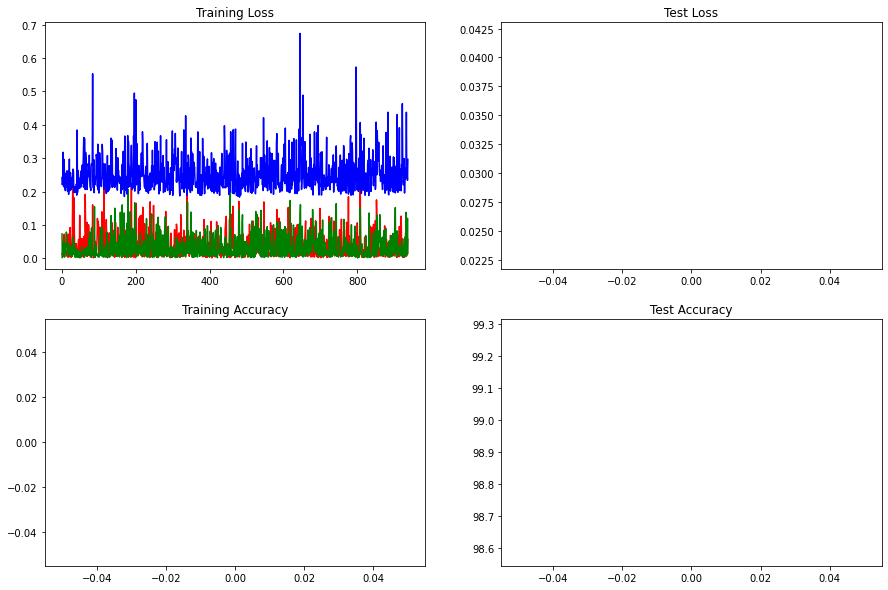

In [77]:
from torch.functional import Tensor
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(torch.stack(gn_train_losses).cpu().detach().numpy(), color='r', label='GN')
axs[0, 0].plot(torch.stack(ln_train_losses).cpu().detach().numpy(), color='g', label='LN')
axs[0, 0].plot(torch.stack(bn_train_losses).cpu().detach().numpy(), color='b', label='L1+BN')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(gn_train_acc[4000:], color='r', label='GN')
axs[1, 0].plot(ln_train_acc[4000:], color='g', label='LN')
axs[1, 0].plot(bn_train_acc[4000:], color='b', label='L1+BN')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(gn_test_losses, color='r', label='GN')
axs[0, 1].plot(ln_test_losses, color='g', label='LN')
axs[0, 1].plot(bn_test_losses, color='b', label='L1+BN')
axs[0, 1].set_title("Test Loss")
#axs[1, 1].plot(test_acc)
axs[1, 1].plot(gn_test_acc, color='r', label='GN')
axs[1, 1].plot(ln_test_acc, color='g', label='LN')
axs[1, 1].plot(bn_test_acc, color='b', label='L1+BN')
axs[1, 1].set_title("Test Accuracy")

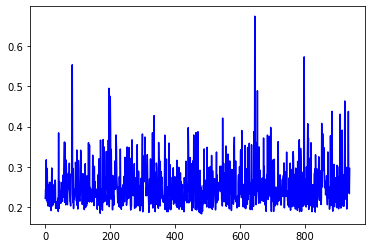

In [75]:
#plt.plot(torch.stack(gn_train_losses).cpu().detach().numpy(), color='r', label='GN')
#plt.plot(torch.stack(ln_train_losses).cpu().detach().numpy(), color='g', label='LN')
plt.plot(torch.stack(bn_train_losses).cpu().detach().numpy(), color='b', label='L1+BN')

In [76]:
for i in range(0, len(gn_train_losses)):
  if gn_train_losses[i].item() != ln_train_losses[i].item() or ln_train_losses[i].item() != bn_train_losses[i].item():
    print('unequal ', gn_train_losses[i], ln_train_losses[i], bn_train_losses[i])
    break

unequal  tensor(0.0129, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.0732, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.2222, device='cuda:0', grad_fn=<AddBackward0>)
